# **TIME SERIES FORECASTING**
## Miranda Leiva Lázaro
---

The next cell installs and imports all the necessary libraries.

In [2]:
!pip install pandas
!pip install sktime
!pip install statsmodels
!pip install matplotlib

import pandas as pd
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
import statsmodels.api as sm
import matplotlib.pyplot as plt

---
### Loading and Analysing Data

I start by importing the data into a Pandas dataframe for a better management and checking its structure.

In [3]:
# Loads the dataset
df = pd.read_csv('../data/salesmonthly.csv')

In [4]:
# Displays the dataset structure
print('The dataset contains', df.shape[0], 'rows and', df.shape[1], 'columns.')

# Displays 5 rows as a sample of the dataset
print('\nA sample of the dataset:')
df.sample(5, random_state=42)

The dataset contains 70 rows and 9 columns.

A sample of the dataset:


,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
22,2015-11-30,152.78,128.233,145.90,1277.725,228.0,18.0,195.0,44.00
0,2014-01-31,127.69,99.090,152.10,878.030,354.0,50.0,112.0,48.20
49,2018-02-28,128.36,132.804,114.65,1255.374,268.0,12.0,253.0,39.06
4,2014-05-31,101.79,119.933,132.10,628.780,270.0,23.0,107.0,123.70
54,2018-07-31,150.18,132.549,87.20,679.350,283.0,19.0,90.0,122.20


The displayed sample helps understanding the purpose of the dataset: It is a monthly sales record of different selected drug groups.

I will print the data type of the variables to check if they make sense with the above displayed sample.

In [6]:
# Prints data types of the columns
df.dtypes

datum     object
M01AB    float64
M01AE    float64
N02BA    float64
N02BE    float64
N05B     float64
N05C     float64
R03      float64
R06      float64
dtype: object

The "datum" column displays a full date, so it can be converted to datetime for better management.
The rest of the the data types do have coherence. Even if some columns display no decimals and could probably be saved as integers, I will keep them as float because it will not affect the forecast.

In [7]:
# Converts the "datum" column to datetime format
df['datum'] = pd.to_datetime(df['datum'])
df.dtypes

datum    datetime64[ns]
M01AB           float64
M01AE           float64
N02BA           float64
N02BE           float64
N05B            float64
N05C            float64
R03             float64
R06             float64
dtype: object

I will check if there are any missing values in the columns.

In [8]:
# Displays the number of missing values by column
print(df.isnull().sum())

datum    0
M01AB    0
M01AE    0
N02BA    0
N02BE    0
N05B     0
N05C     0
R03      0
R06      0
dtype: int64


There are no null values.

---
### Data forecasting

The time range values to be predicted can be obtained by using the python sktime library for time series forecasting. Its implementation requires the dataframe index to be a datetime sequence, without duplicated dates. To accomplish this, I will use the column related to time ("datum") and set it as the index.

In [10]:
# Sets the "datum" column as the index
df = df.set_index('datum')

In [11]:
# Displays first rows of the dataset to check the sorting by time
print('\nFirst rows of the dataset:')
df.head()


First rows of the dataset:


,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
datum,,,,,,,,
2014-01-31,127.69,99.090,152.100,878.030,354.0,50.0,112.0,48.2
2014-02-28,133.32,126.050,177.000,1001.900,347.0,31.0,122.0,36.2
2014-03-31,137.44,92.950,147.655,779.275,232.0,20.0,112.0,85.4
2014-04-30,113.10,89.475,130.900,698.500,209.0,18.0,97.0,73.7
2014-05-31,101.79,119.933,132.100,628.780,270.0,23.0,107.0,123.7


I can display the evolution in the drug sales month by month.

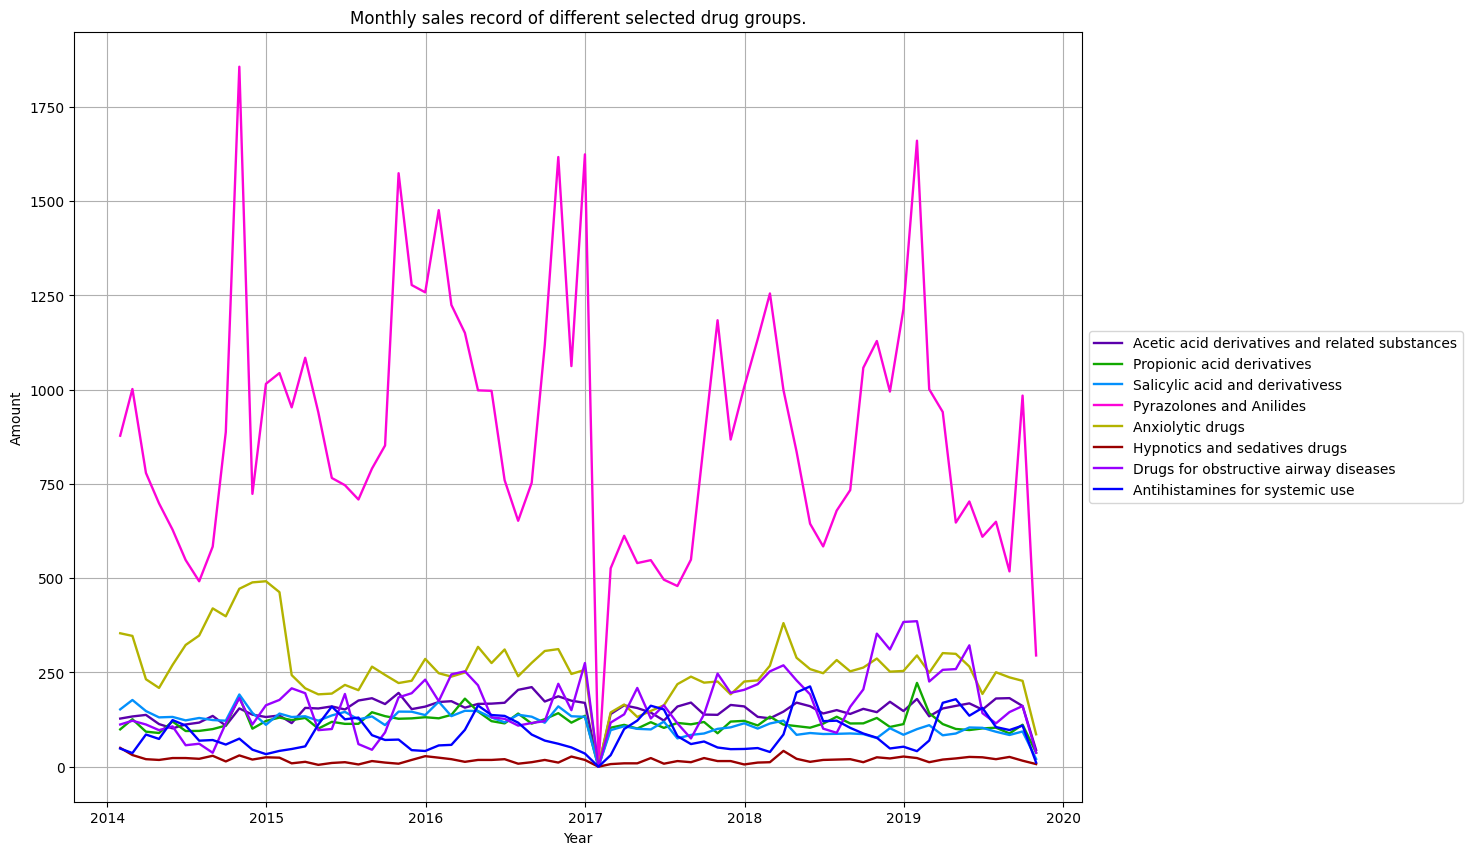

In [72]:
# Plots the evolution of the data
plt.figure(figsize=(13, 10))

plt.plot(df.index, df['M01AB'], label='Acetic acid derivatives and related substances', linewidth=1.7, color='#5b00ab')
plt.plot(df.index, df['M01AE'], label='Propionic acid derivatives', linewidth=1.7, color='#11a800')
plt.plot(df.index, df['N02BA'], label='Salicylic acid and derivativess', linewidth=1.7, color='#0390fc')
plt.plot(df.index, df['N02BE'], label='Pyrazolones and Anilides', linewidth=1.7, color='#fc03d7')
plt.plot(df.index, df['N05B'], label='Anxiolytic drugs', linewidth=1.7, color='#b3b300')
plt.plot(df.index, df['N05C'], label='Hypnotics and sedatives drugs', linewidth=1.7, color='#990000')
plt.plot(df.index, df['R03'], label='Drugs for obstructive airway diseases', linewidth=1.7, color='#9900ff')
plt.plot(df.index, df['R06'], label='Antihistamines for systemic use', linewidth=1.7, color='#0000ff')


plt.title('Monthly sales record of different selected drug groups.', fontsize=12)
plt.xlabel('Year')
plt.ylabel('Amount')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

plt.show()

I will define the train-test sets, create the forecast models and train them, for each drug group. It is necessary for the models to previously define the frequence of the data, which is monthly. I will also obtain at first the number of rows to predict to define it in the forecast horizon, and in which month do they start.

In [39]:
# Defines the frequence of the data in the index as beginning of the month and then as monthly
df_2 = df.copy()
df_2.index = df.index.to_period('M')

# Displays first and last rows of the dataset to check the sorting by month
print('\nFirst rows of the dataset:')
df_2.head()


First rows of the dataset:


,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
datum,,,,,,,,
2014-01,127.69,99.090,152.100,878.030,354.0,50.0,112.0,48.2
2014-02,133.32,126.050,177.000,1001.900,347.0,31.0,122.0,36.2
2014-03,137.44,92.950,147.655,779.275,232.0,20.0,112.0,85.4
2014-04,113.10,89.475,130.900,698.500,209.0,18.0,97.0,73.7
2014-05,101.79,119.933,132.100,628.780,270.0,23.0,107.0,123.7


In [41]:
print('\nLast rows of the dataset:')
df_2.tail()


Last rows of the dataset:


,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
datum,,,,,,,,
2019-06,151.54,101.627,103.20,610.00,193.0,25.0,142.0,156.04
2019-07,181.00,103.541,92.80,649.80,250.6,20.0,115.0,105.20
2019-08,181.91,88.269,84.20,518.10,237.0,26.0,145.0,97.30
2019-09,161.07,111.437,93.50,984.48,227.8,16.0,161.0,109.10
2019-10,44.37,37.300,20.65,295.15,86.0,7.0,37.0,11.13


The last record is from October 2019. Therefore, the time range to predict will start with November 2019. I will make predictions for 12 months (this will be the number of predictions to be made).

In [48]:
# FORECAST FOR GROUP M01AB
# Defines the train and test dataframes required to perform the forecast
df_train_1, df_test_1 = temporal_train_test_split(df_2['M01AB'], train_size=0.8)

# Defines a forecast horizon
fh_1 = ForecastingHorizon(pd.period_range(start='2019-11', periods=12, freq='M'), is_relative=False)

# Defines a forecasting model
forecaster_1 = ThetaForecaster(deseasonalize=False)

# Trains the model
forecaster_1.fit(df_train_1)


# FORECAST FOR GROUP M01AE
# Defines the train and test dataframes required to perform the forecast
df_train_2, df_test_2 = temporal_train_test_split(df_2['M01AE'], train_size=0.8)

# Defines a forecast horizon
fh_2 = ForecastingHorizon(pd.period_range(start='2019-11', periods=12, freq='M'), is_relative=False)

# Defines a forecasting model
forecaster_2 = ThetaForecaster(deseasonalize=False)

# Trains the model
forecaster_2.fit(df_train_2)


# FORECAST FOR GROUP N02BA
# Defines the train and test dataframes required to perform the forecast
df_train_3, df_test_3 = temporal_train_test_split(df_2['N02BA'], train_size=0.8)

# Defines a forecast horizon
fh_3 = ForecastingHorizon(pd.period_range(start='2019-11', periods=12, freq='M'), is_relative=False)

# Defines a forecasting model
forecaster_3 = ThetaForecaster(deseasonalize=False)

# Trains the model
forecaster_3.fit(df_train_3)


# FORECAST FOR GROUP N02BE
# Defines the train and test dataframes required to perform the forecast
df_train_4, df_test_4 = temporal_train_test_split(df_2['N02BE'], train_size=0.8)

# Defines a forecast horizon
fh_4 = ForecastingHorizon(pd.period_range(start='2019-11', periods=12, freq='M'), is_relative=False)

# Defines a forecasting model
forecaster_4 = ThetaForecaster(deseasonalize=False)

# Trains the model
forecaster_4.fit(df_train_4)


# FORECAST FOR GROUP N05B
# Defines the train and test dataframes required to perform the forecast
df_train_5, df_test_5 = temporal_train_test_split(df_2['N05B'], train_size=0.8)

# Defines a forecast horizon
fh_5 = ForecastingHorizon(pd.period_range(start='2019-11', periods=12, freq='M'), is_relative=False)

# Defines a forecasting model
forecaster_5 = ThetaForecaster(deseasonalize=False)

# Trains the model
forecaster_5.fit(df_train_5)


# FORECAST FOR GROUP N05C
# Defines the train and test dataframes required to perform the forecast
df_train_6, df_test_6 = temporal_train_test_split(df_2['N05C'], train_size=0.8)

# Defines a forecast horizon
fh_6 = ForecastingHorizon(pd.period_range(start='2019-11', periods=12, freq='M'), is_relative=False)

# Defines a forecasting model
forecaster_6 = ThetaForecaster(deseasonalize=False)

# Trains the model
forecaster_6.fit(df_train_6)


# FORECAST FOR GROUP R03
# Defines the train and test dataframes required to perform the forecast
df_train_7, df_test_7 = temporal_train_test_split(df_2['R03'], train_size=0.8)

# Defines a forecast horizon
fh_7 = ForecastingHorizon(pd.period_range(start='2019-11', periods=12, freq='M'), is_relative=False)

# Defines a forecasting model
forecaster_7 = ThetaForecaster(deseasonalize=False)

# Trains the model
forecaster_7.fit(df_train_7)


# FORECAST FOR GROUP R06
# Defines the train and test dataframes required to perform the forecast
df_train_8, df_test_8 = temporal_train_test_split(df_2['R06'], train_size=0.8)

# Defines a forecast horizon
fh_8 = ForecastingHorizon(pd.period_range(start='2019-11', periods=12, freq='M'), is_relative=False)

# Defines a forecasting model
forecaster_8 = ThetaForecaster(deseasonalize=False)

# Trains the model
forecaster_8.fit(df_train_8)

ThetaForecaster(deseasonalize=False)

Now that the models are ready, I can make predictions for the defined forecast horizons and check the results.

In [49]:
# Makes predictions for the forecast horizons
pred_1 = forecaster_1.predict(fh_1)
pred_2 = forecaster_2.predict(fh_2)
pred_3 = forecaster_3.predict(fh_3)
pred_4 = forecaster_4.predict(fh_4)
pred_5 = forecaster_5.predict(fh_5)
pred_6 = forecaster_6.predict(fh_6)
pred_7 = forecaster_7.predict(fh_7)
pred_8 = forecaster_8.predict(fh_8)

In [50]:
# Displays the forecasted values for the "M01AB" column as an example
print('Forecast for "M01AB":')
pred_1

Forecast for "M01AB":


2019-11    150.864903
2019-12    151.035680
2020-01    151.206458
2020-02    151.377235
2020-03    151.548013
2020-04    151.718790
2020-05    151.889568
2020-06    152.060345
2020-07    152.231123
2020-08    152.401901
2020-09    152.572678
2020-10    152.743456
Freq: M, Name: M01AB, dtype: float64

The forecasting has succeed.

---
### Data visualization

I will now display the evolution and forecast of the different drug group sales, month by month, all together in a graph.

To show a single continuous timeline, I put all the data together and then divide it into records and predictions.

In [66]:
df_complete = pd.DataFrame({'M01AB': pd.concat([df_2['M01AB'], pred_1]),
                            'M01AE': pd.concat([df_2['M01AE'], pred_2]),
                            'N02BA': pd.concat([df_2['N02BA'], pred_3]),
                            'N02BE': pd.concat([df_2['N02BE'], pred_4]),
                            'N05B': pd.concat([df_2['N05B'], pred_5]),
                            'N05C': pd.concat([df_2['N05C'], pred_6]),
                            'R03': pd.concat([df_2['R03'], pred_7]),
                            'R06': pd.concat([df_2['R06'], pred_8]),                            
                        })

df_complete.index = df_complete.index.to_timestamp()
df_complete = df_complete.sort_index()

In [67]:
# Displays first and last rows of the complete dataset
print('\nFirst rows of the dataset:')
df_complete.head()


First rows of the dataset:


,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
2014-01-01,127.69,99.090,152.100,878.030,354.0,50.0,112.0,48.2
2014-02-01,133.32,126.050,177.000,1001.900,347.0,31.0,122.0,36.2
2014-03-01,137.44,92.950,147.655,779.275,232.0,20.0,112.0,85.4
2014-04-01,113.10,89.475,130.900,698.500,209.0,18.0,97.0,73.7
2014-05-01,101.79,119.933,132.100,628.780,270.0,23.0,107.0,123.7


In [68]:
print('\nLast rows of the dataset:')
df_complete.tail()


Last rows of the dataset:


,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
2020-06-01,152.060345,114.022036,79.095552,706.550900,230.900389,17.022139,160.335684,109.850669
2020-07-01,152.231123,113.992139,78.549203,705.621255,229.793699,16.950146,161.013850,110.144177
2020-08-01,152.401901,113.962242,78.002854,704.691610,228.687009,16.878154,161.692016,110.437684
2020-09-01,152.572678,113.932345,77.456505,703.761964,227.580319,16.806161,162.370181,110.731191
2020-10-01,152.743456,113.902449,76.910156,702.832319,226.473628,16.734169,163.048347,111.024699


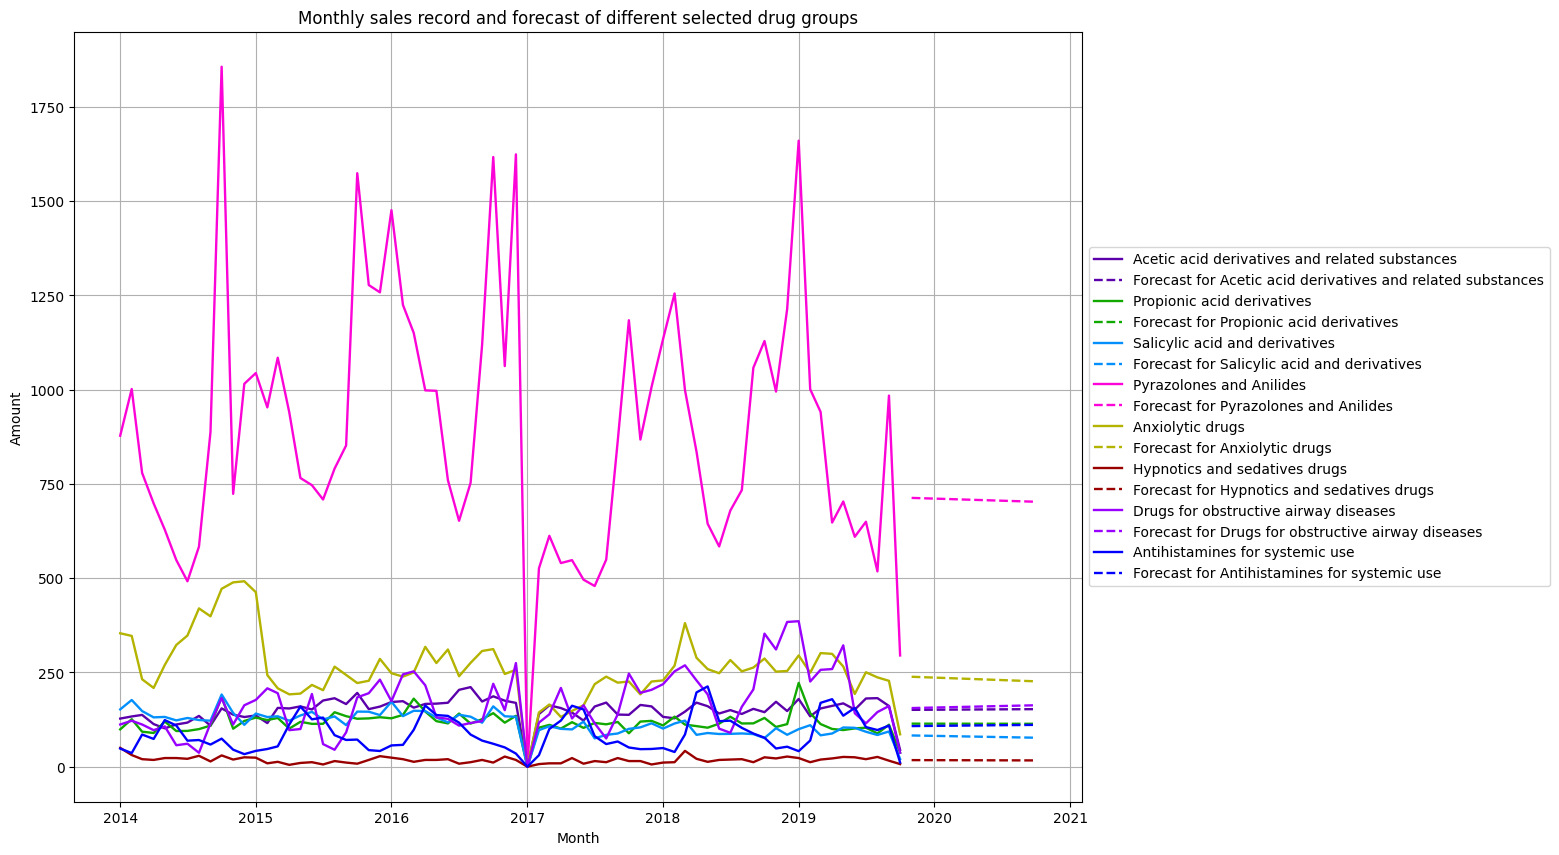

In [73]:
# Plots the evolution of the data by month and the forecast
plt.figure(figsize=(13, 10))

plt.plot(df_complete.loc[:'2019-10', 'M01AB'], label='Acetic acid derivatives and related substances', linewidth=1.7, color='#5b00ab')
plt.plot(df_complete.loc['2019-11':, 'M01AB'], label='Forecast for Acetic acid derivatives and related substances', linewidth=1.7, color='#5b00ab', linestyle='dashed')

plt.plot(df_complete.loc[:'2019-10', 'M01AE'], label='Propionic acid derivatives', linewidth=1.7, color='#11a800')
plt.plot(df_complete.loc['2019-11':, 'M01AE'], label='Forecast for Propionic acid derivatives', linewidth=1.7, color='#11a800', linestyle='dashed')

plt.plot(df_complete.loc[:'2019-10', 'N02BA'], label='Salicylic acid and derivatives', linewidth=1.7, color='#0390fc')
plt.plot(df_complete.loc['2019-11':, 'N02BA'], label='Forecast for Salicylic acid and derivatives', linewidth=1.7, color='#0390fc', linestyle='dashed')

plt.plot(df_complete.loc[:'2019-10', 'N02BE'], label='Pyrazolones and Anilides', linewidth=1.7, color='#fc03d7')
plt.plot(df_complete.loc['2019-11':, 'N02BE'], label='Forecast for Pyrazolones and Anilides', linewidth=1.7, color='#fc03d7', linestyle='dashed')

plt.plot(df_complete.loc[:'2019-10', 'N05B'], label='Anxiolytic drugs', linewidth=1.7, color='#b3b300')
plt.plot(df_complete.loc['2019-11':, 'N05B'], label='Forecast for Anxiolytic drugs', linewidth=1.7, color='#b3b300', linestyle='dashed')

plt.plot(df_complete.loc[:'2019-10', 'N05C'], label='Hypnotics and sedatives drugs', linewidth=1.7, color='#990000')
plt.plot(df_complete.loc['2019-11':, 'N05C'], label='Forecast for Hypnotics and sedatives drugs', linewidth=1.7, color='#990000', linestyle='dashed')

plt.plot(df_complete.loc[:'2019-10', 'R03'], label='Drugs for obstructive airway diseases', linewidth=1.7, color='#9900ff')
plt.plot(df_complete.loc['2019-11':, 'R03'], label='Forecast for Drugs for obstructive airway diseases', linewidth=1.7, color='#9900ff', linestyle='dashed')

plt.plot(df_complete.loc[:'2019-10', 'R06'], label='Antihistamines for systemic use', linewidth=1.7, color='#0000ff')
plt.plot(df_complete.loc['2019-11':, 'R06'], label='Forecast for Antihistamines for systemic use', linewidth=1.7, color='#0000ff', linestyle='dashed')

plt.title('Monthly sales record and forecast of different selected drug groups', fontsize=12)
plt.xlabel('Month')
plt.ylabel('Amount')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

plt.show()

The forecast reveals that drug sales will be around 80 and 160 for most of the groups, with a relative continuity. The sales of hypnotics and sedatives drugs will be only around 10. On the other hand, the sales of anxiolytic drugs will be around 240, with a slight decrease.
The number of predicted sales for the pyrazolones and anilides group presents an outlier value of around 730. A slight decrease is forecasted.